# Vendor and Magnetic Field Strenght Classification of Magnetic Resonance Images

- Calgary-Campinas Dataset: https://sites.google.com/view/calgary-campinas-dataset/home
- Three vendors: Philips, GE, Siemens\
- Two magnetic fields: 1.5 T and 3 T

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,MaxPooling2D,Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Loading data
samples = np.load("../Data/cc_samples.npy")
field_labels = np.load("../Data/magnetic_field_labels.npy").astype(int)
vendor_labels = np.load("../Data/scanner_vendor_labels.npy").astype(int) 
age_labels = np.load("../Data/age_labels.npy")
labels = 3*field_labels + vendor_labels # combined vendor + field label - labels go from 0 to 5

# Shuffling samples
indexes = np.arange(samples.shape[0],dtype = int)
np.random.shuffle(indexes)
samples = samples[indexes]
field_labels = field_labels[indexes]
vendor_labels = vendor_labels[indexes]
age_labels = age_labels[indexes]
labels = labels[indexes]

# Labels mapping
field_dic = {"0":"1.5 T","1":"3 T"}
vendor_dic = {"0":"Philips","1":"GE","2":"Siemens"}

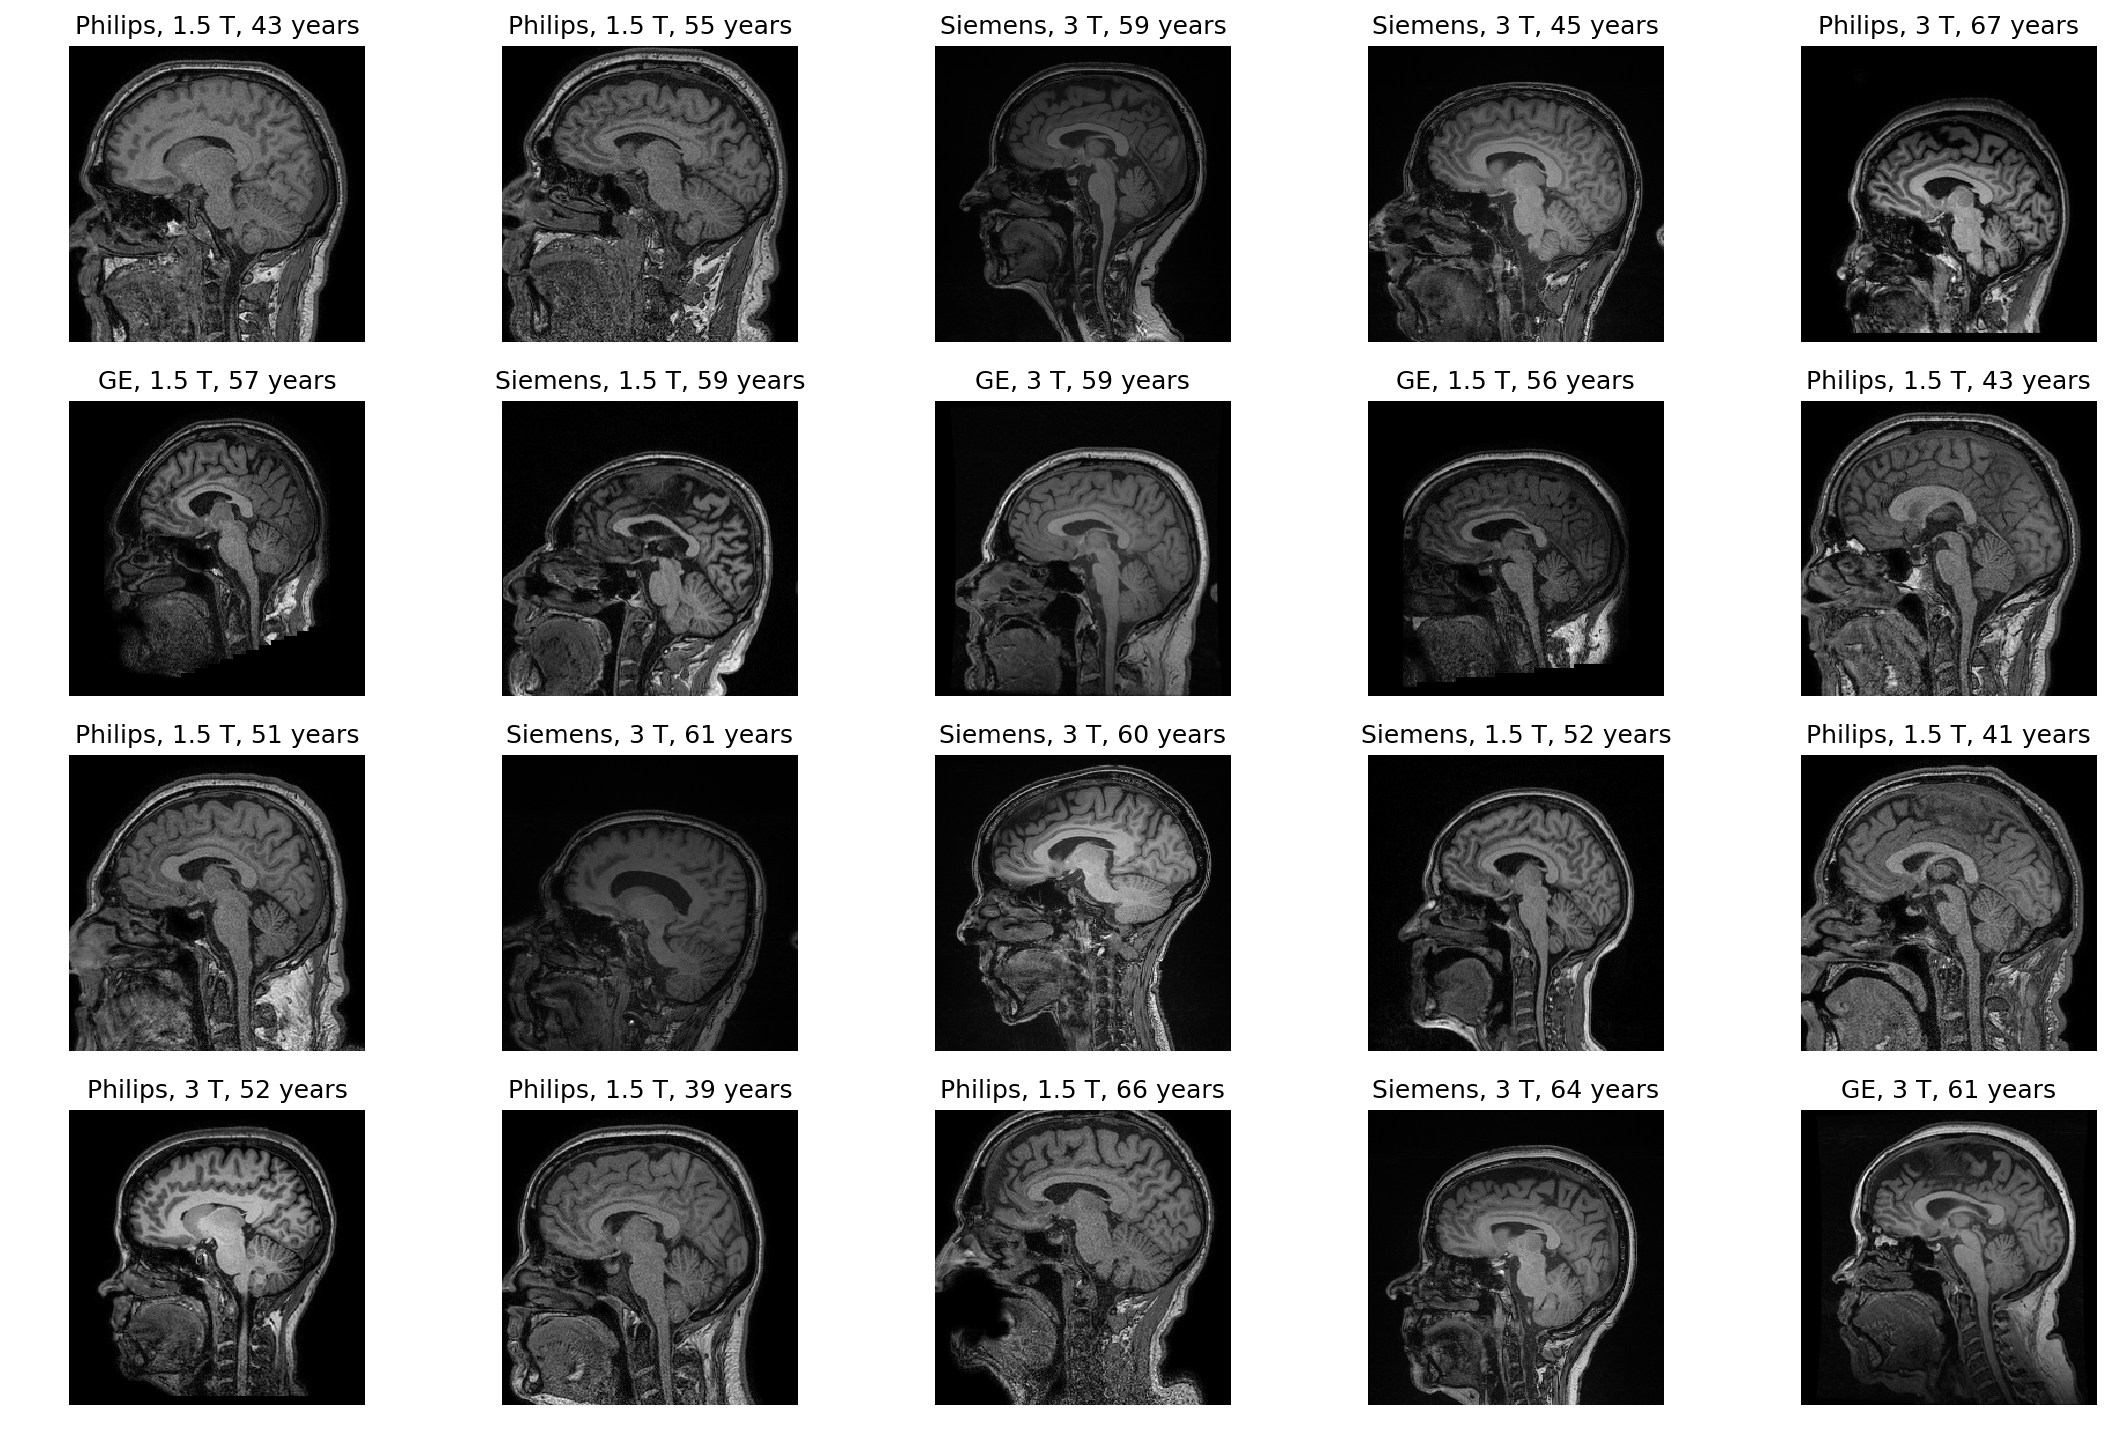

In [3]:
# Display some samples
skip = 180
plt.figure(dpi = 150, figsize = (18,12))
for ii in range(20):
    plt.subplot(4,5,ii+1)
    plt.imshow(samples[ii*skip],cmap = "gray")
    plt.axis("off")
    plt.title("%s, %s, %d years" %(vendor_dic[str(vendor_labels[ii*skip])],field_dic[str(field_labels[ii*skip])],\
              age_labels[ii*skip]))
plt.show()

In [16]:
# STratified splitting into train/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(samples,labels)
train_index, test_index = next(sss.split(samples,labels))

samples_train = samples[train_index]
labels_train = labels[train_index] 
field_labels_train = field_labels[train_index]
vendor_labels_train = vendor_labels[train_index]
age_labels_train = age_labels[train_index]



samples_test = samples[test_index]
labels_test = labels[test_index] 
field_labels_test = field_labels[test_index]
vendor_labels_test = vendor_labels[test_index]
age_labels_test = age_labels[test_index]

# One-hot-encoding -is the format used as input when training the network
labels_train = tf.keras.utils.to_categorical(labels_train, 6)

In [9]:
# Our model
def my_model(input_shape):
    input_signal = Input(input_shape)
    
    # First block
    conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(input_signal)
    conv1 = Conv2D(32,kernel_size=(3,3),activation="relu")(conv1)
    conv1 = Conv2D(32,kernel_size=(3,3),activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    drop1 = Dropout(0.25)(pool1)
    
    # Second block
    conv2 = Conv2D(48, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(drop1)
    conv2 = Conv2D(48,kernel_size=(3,3),activation="relu")(conv2)
    conv2 = Conv2D(48,kernel_size=(3,3),activation="relu")(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    drop2 = Dropout(0.25)(pool2)
    
    # Third block
    conv3 = Conv2D(64, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(drop2)
    conv3 = Conv2D(64,kernel_size=(3,3),activation="relu")(conv3)
    conv3 = Conv2D(64,kernel_size=(3,3),activation="relu")(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    drop3 = Dropout(0.25)(pool3)
    
    flat = Flatten()(drop3)
    prediction = Dense(6,activation = 'softmax')(flat)
    
    model = Model(inputs=input_signal, outputs=prediction)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

In [10]:
#Building the model and showing a summary
model = my_model((256,256,1))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 250, 250, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 123, 123, 48)      1387

In [11]:
model_name = 'vendor_field_cnn.h5'
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint(model_name, monitor='val_loss'
                             ,verbose=0,save_weights_only= True,
                             save_best_only=True)

history = model.fit(samples_train[:,:,:,np.newaxis], labels_train,\
                    batch_size=16,
                    epochs=5,
                    verbose=1,
                    validation_split= 0.2,callbacks = [checkpoint],shuffle = True)

Train on 2153 samples, validate on 539 samples
Epoch 1/5
2153/2153 [==============================] - 346s 161ms/sample - loss: 0.6047 - accuracy: 0.7729 - val_loss: 0.1070 - val_accuracy: 0.9610
Epoch 2/5
2153/2153 [==============================] - 360s 167ms/sample - loss: 0.1058 - accuracy: 0.9652 - val_loss: 0.0339 - val_accuracy: 0.9889
Epoch 3/5
 496/2153 [=====>........................] - ETA: 4:26 - loss: 0.0682 - accuracy: 0.9792

W1118 09:54:37.328160 139638814021440 callbacks.py:990] Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [12]:
# Testing the model
model.load_weights(model_name)
pred = np.argmax(model.predict(samples_test[:,:,:,np.newaxis]),axis = 1) # Label is the one with maximum probability
print("Test set accuracy:", (pred == labels_test).sum()/pred.size)

Test set accuracy: 0.9922048997772829


[106 262 264 330 437 884 886]


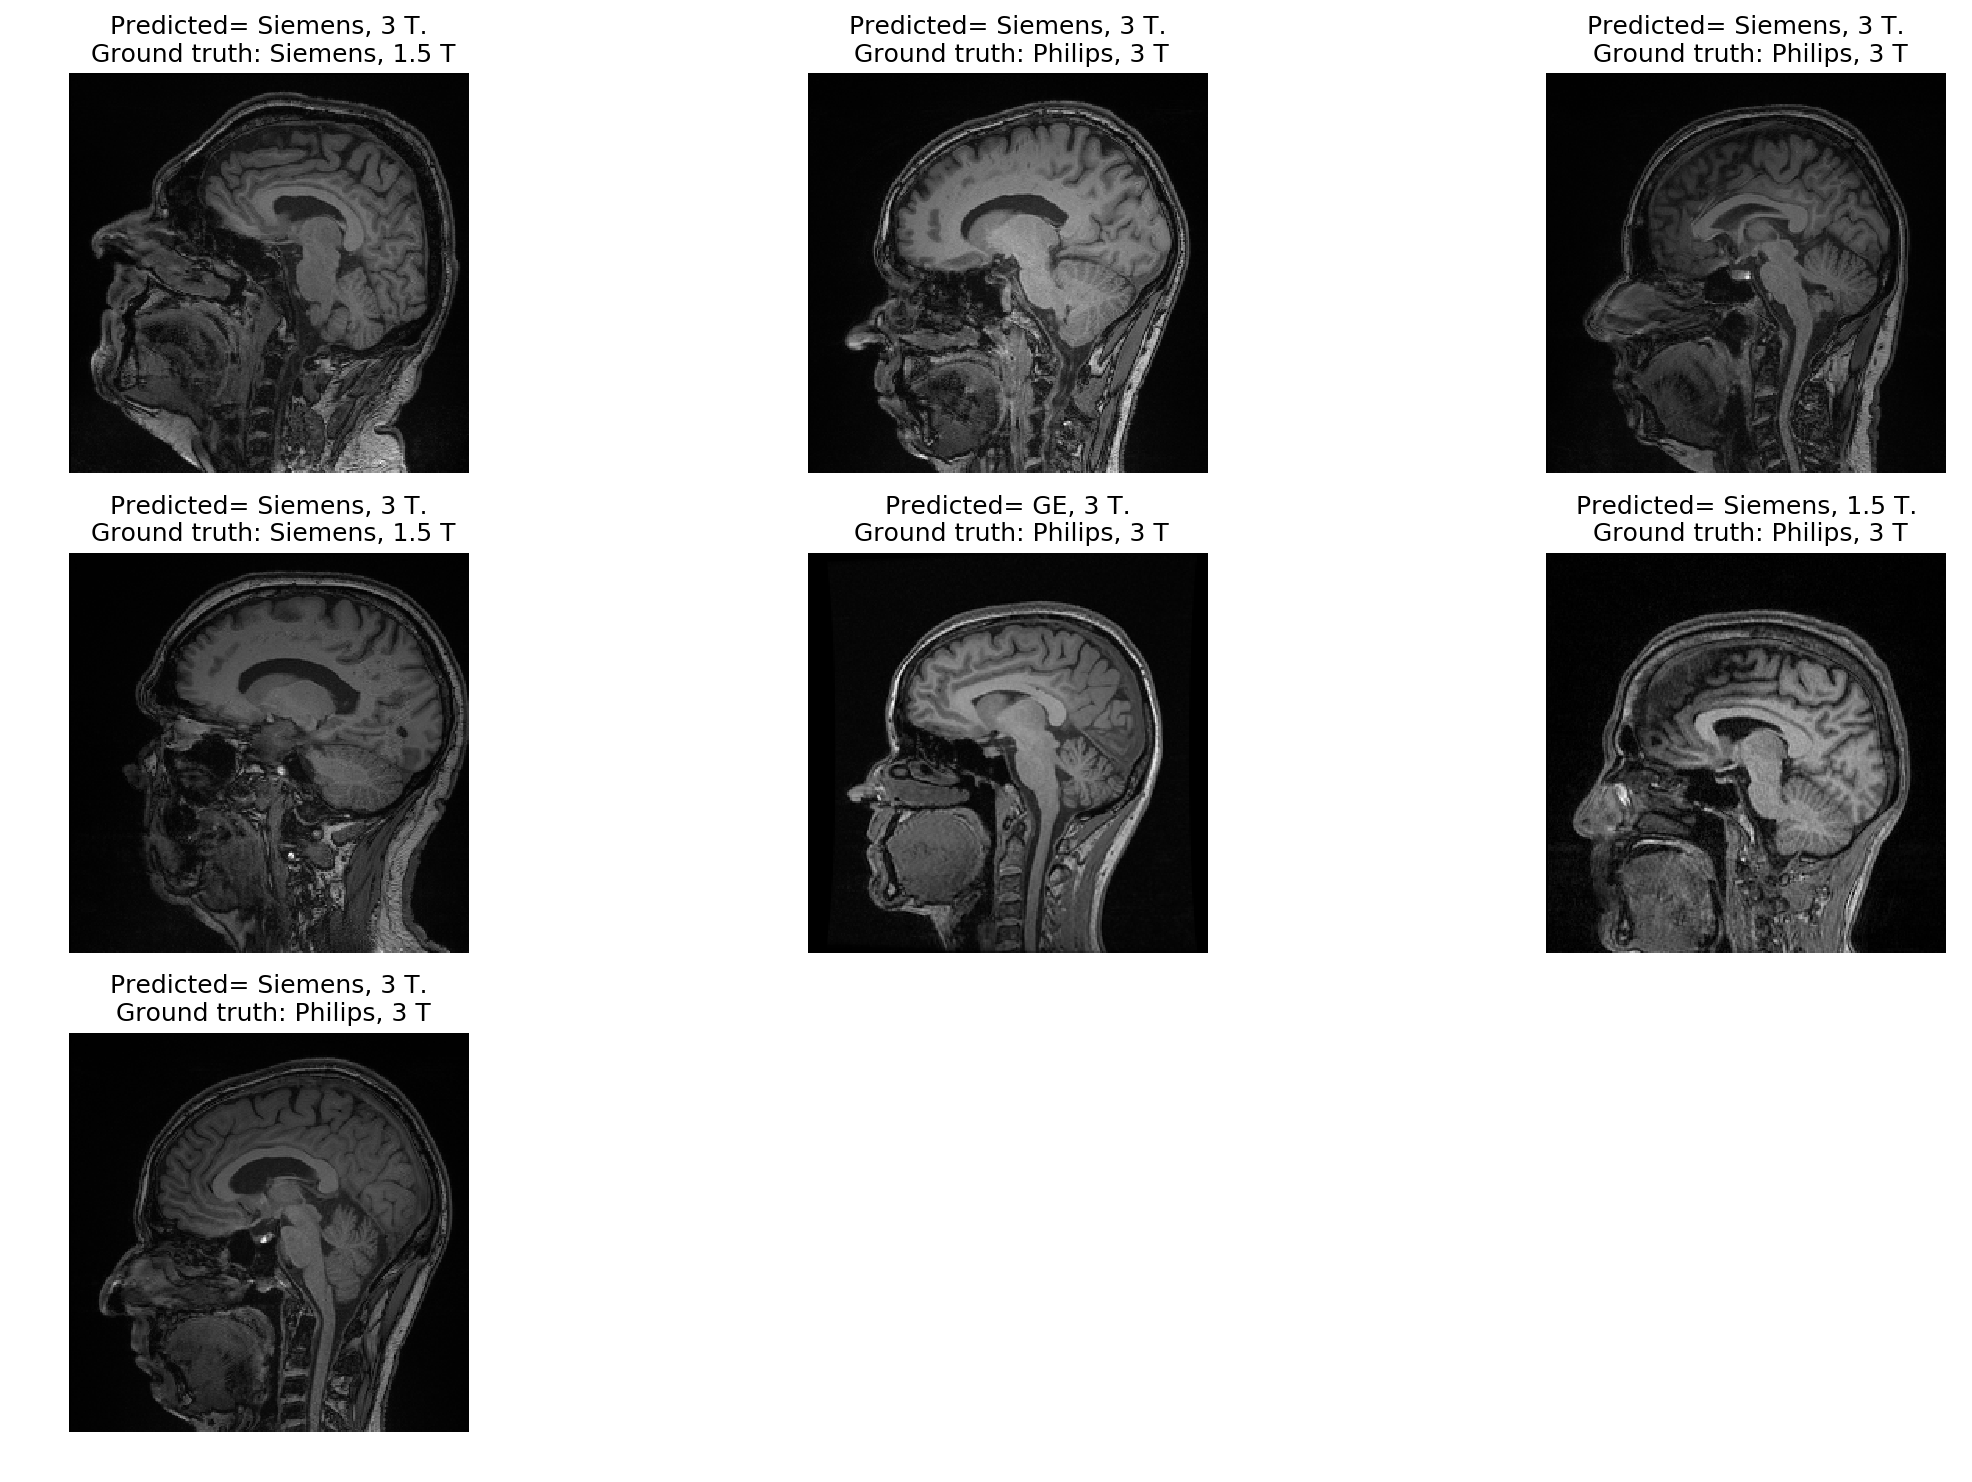

In [24]:
# Display some samples
mistakes = np.where(pred != labels_test)[0]
print(mistakes)
cols = 3
rows = np.ceil(mistakes.size/cols)

plt.figure(dpi = 150, figsize = (18,12))
counter = 1
for ii in mistakes:
    plt.subplot(rows,cols,counter)
    plt.imshow(samples_test[ii],cmap = "gray")
    plt.axis("off")
    plt.title("Predicted= %s, %s.\n Ground truth: %s, %s" %(vendor_dic[str(vendor_labels_test[ii])],\
                                                          field_dic[str(field_labels_test[ii])],\
                                                          vendor_dic[str(pred[ii]%3)],\
                                                          field_dic[str(pred[ii]//3)]))
    counter+=1
plt.show()